# Section 7 - assignment

>Simon Ward-Jones - November 2020

**Steps**

---
    1. Connect to kaggle via api and download data
        a. Read kaggle api tokens from google drive
        b. Download data using kaggle package
    2. Explore data and prepare PyToch dataset and dataloader
    3. Create net - explaining architecture
    4. Train
    5. Make prediction and print accuracy



## Connect to kaggle via api and download data

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
# copy credentials for kaggle to colab env
!mkdir /root/.kaggle
!cp '/content/gdrive/MyDrive/Data Science/D2L/kaggle.json' '/root/.kaggle/kaggle.json'

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [14]:
# Install kaggle packages
!pip install -q kaggle-cli
!pip install -qU plotly ipywidgets

     |████████████████████████████████| 81kB 8.7MB/s 
     |████████████████████████████████| 5.3MB 14.9MB/s 
     |████████████████████████████████| 112kB 58.5MB/s 
     |████████████████████████████████| 133kB 63.5MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 13.1MB 248kB/s 


In [15]:
# Download the dataset using kaggle api
!kaggle datasets download -d ashishsaxena2209/animal-image-datasetdog-cat-and-panda

 98% 368M/376M [00:03<00:00, 85.6MB/s]
100% 376M/376M [00:03<00:00, 106MB/s] 


In [16]:
# Extract the folder (-o overwrite, -q quiet) to current dir
!unzip -oq animal-image-datasetdog-cat-and-panda.zip

In [17]:
ls animals/animals

cats/  dogs/  panda/


## Explore data and prepare PyToch dataset and dataloader

In [18]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets

from sklearn.model_selection import train_test_split
from IPython.display import display

In [19]:
# Load the dataset using the torchvision imagefolder dataset
# datasets.ImageFolder??
resize = (224, 224)
cats_dogs_pandas = datasets.ImageFolder(
    root='./animals/animals',
    transform=transforms.Resize(resize))

In [20]:
cats_dogs_pandas.class_to_idx # map labels to integers
# cats_dogs_pandas.imgs[:3] # image paths and labels

{'cats': 0, 'dogs': 1, 'panda': 2}

Displaying image 0 with label 0:


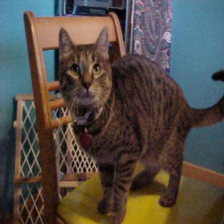

Displaying image 1000 with label 1:


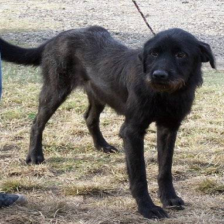

Displaying image 2000 with label 2:


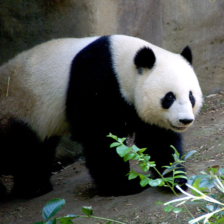

In [21]:

for i in range(3):
    idx = i * 1000
    print(f'Displaying image {idx} with label {cats_dogs_pandas[idx][1]}:')
    display(cats_dogs_pandas[idx][0])

## Train test split

We want to acheive a stratified split

In [22]:
train_idx, test_idx= train_test_split(
    torch.arange(len(cats_dogs_pandas.targets)),
    test_size=0.2,
    shuffle=True,
    stratify=cats_dogs_pandas.targets)

In [23]:
targets = torch.Tensor(cats_dogs_pandas.targets) 

In [24]:
# Show targets are balanced:
for label in [0, 1, 2]:
  print(
      f'There are {(targets[train_idx] == label).sum()}'
      f' {label}\'s in the training data')


There are 800 0's in the training data
There are 800 1's in the training data
There are 800 2's in the training data


In [25]:
# Settings for training
batch_size = 64
lr = 0.04
num_epochs = 10

# Now load the data into train/test with transforms
data_transform = transforms.Compose([
    transforms.Resize(resize),
    transforms.ToTensor()
])

cats_dogs_pandas = datasets.ImageFolder(
    root='./animals/animals',
    transform=data_transform)

train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(
    dataset=cats_dogs_pandas,
    batch_size=batch_size,
    sampler=train_sampler)
test_loader = DataLoader(
    dataset=cats_dogs_pandas,
    batch_size=batch_size,
    sampler=test_sampler)

In [26]:
for X, y in train_loader:
    break

In [27]:
X.shape # 64 in batch, 3 channels, 256  width, 256 height

torch.Size([64, 3, 224, 224])

## Define Alex net model

In [28]:
net = nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Linear(6400, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 3)
)

In [29]:
# Alex nets shapes:
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'Output shape:\t', X.shape)

Conv2d Output shape:	 torch.Size([64, 96, 54, 54])
ReLU Output shape:	 torch.Size([64, 96, 54, 54])
MaxPool2d Output shape:	 torch.Size([64, 96, 26, 26])
Conv2d Output shape:	 torch.Size([64, 256, 26, 26])
ReLU Output shape:	 torch.Size([64, 256, 26, 26])
MaxPool2d Output shape:	 torch.Size([64, 256, 12, 12])
Conv2d Output shape:	 torch.Size([64, 384, 12, 12])
ReLU Output shape:	 torch.Size([64, 384, 12, 12])
Conv2d Output shape:	 torch.Size([64, 384, 12, 12])
ReLU Output shape:	 torch.Size([64, 384, 12, 12])
Conv2d Output shape:	 torch.Size([64, 256, 12, 12])
ReLU Output shape:	 torch.Size([64, 256, 12, 12])
MaxPool2d Output shape:	 torch.Size([64, 256, 5, 5])
Flatten Output shape:	 torch.Size([64, 6400])
Linear Output shape:	 torch.Size([64, 4096])
ReLU Output shape:	 torch.Size([64, 4096])
Dropout Output shape:	 torch.Size([64, 4096])
Linear Output shape:	 torch.Size([64, 4096])
ReLU Output shape:	 torch.Size([64, 4096])
Dropout Output shape:	 torch.Size([64, 4096])
Linear Output sh

## Train net

In [30]:
from IPython import display
display.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from IPython.display import clear_output



In [31]:
class PlotlyAnimator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None, ylim=None):
        fig = go.FigureWidget()
        # update layout 
        fig.layout.xaxis.title = xlabel
        fig.layout.yaxis.title = ylabel
        fig.layout.xaxis.range  = xlim
        fig.layout.yaxis.range  = ylim
        self.legend=legend
        self.X, self.Y, self.fig = None, None, fig

    def _repr_html_(self):
        return self.fig._repr_html_()

    def add(self, x, y):
        # y has length number of series, copy x for each series
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        if not self.fig.data:
            for _ in range(n):
                self.fig.add_trace(go.Scatter())
        if self.legend:
            for trace, series_name in zip(self.fig.data, self.legend):
                trace.name = series_name
        for x, y, fig_data in zip(self.X, self.Y, self.fig.data):
            fig_data.x = x
            fig_data.y = y
        clear_output()
        self.fig.show()

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:  #@save
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)        
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """Compute the accuracy for a model on a dataset using a GPU."""
    net.eval()  # Set the model to evaluation mode
    if not device:
        device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train_net(net,
              train_loader, 
              test_loader, 
              num_epochs, 
              lr, 
              device=try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = PlotlyAnimator(
        xlabel='epoch',
        xlim=[0, num_epochs],
        legend=['train loss', 'train acc', 'test acc'])
    num_batches = len(train_loader)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        for i, (X, y) in enumerate(train_loader):
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            train_l = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_loader)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

In [32]:
# Train model or load model
TRAIN = True
PATH = './model.pkl'
if TRAIN:
    train_net(net, train_loader, test_loader, num_epochs, lr)
else:
    !cp '/content/gdrive/MyDrive/Data Science/D2L/model.pkl' '/content/model.pkl' 
    net.load_state_dict(torch.load(PATH))

loss 0.710, train acc 0.615, test acc 0.580


## Load model

In [33]:
# Train model or load model
TRAIN = False
PATH = './model.pkl'
if TRAIN:
    train_net(net, train_loader, test_loader, num_epochs, lr)
else:
    !cp '/content/gdrive/MyDrive/Data Science/D2L/model.pkl' '/content/model.pkl' 
    net.load_state_dict(torch.load(PATH))

In [34]:
next(net.parameters()).is_cuda

True

In [35]:
net.training

False

## Save the model

In [36]:
torch.save(net.state_dict(), PATH)

In [37]:
# See the model.pkl
!ls

animal-image-datasetdog-cat-and-panda.zip  gdrive  model.pkl
animals					   images  sample_data


In [38]:
# copy the model to drive for later
!cp '/content/model.pkl' '/content/gdrive/MyDrive/Data Science/D2L/model.pkl'

## Prediction examples

Prediction: dogs, Acutal dogs


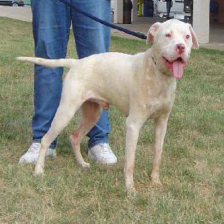

Prediction: cats, Acutal panda


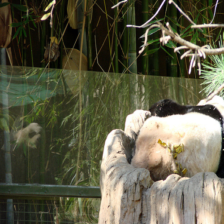

Prediction: panda, Acutal panda


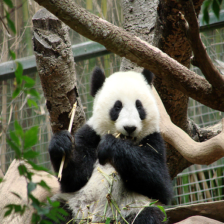

In [43]:
idx_to_class  = {v : k for k, v in cats_dogs_pandas.class_to_idx.items()}
to_pil_image = transforms.ToPILImage()

sample = 3
for X, y in test_loader:
    X = X[:sample,:].cuda()
    y = y[:sample]
    y_hat = net(X)
    preds = [idx_to_class[pred] 
             for pred in net(X).argmax(axis=1).to('cpu').numpy()]
    break
for id in range(sample):
    print(f'Prediction: {preds[id]}, Acutal {idx_to_class[y.numpy()[id]]}')
    display.display(to_pil_image(X[id]))
